<a href="https://colab.research.google.com/github/jonathancagua/IA-PINN/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

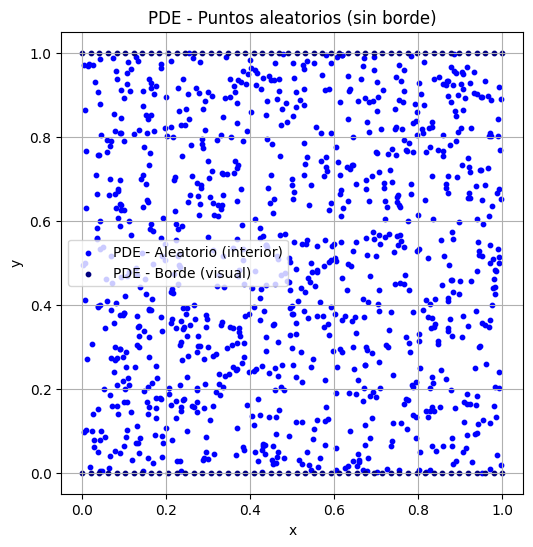

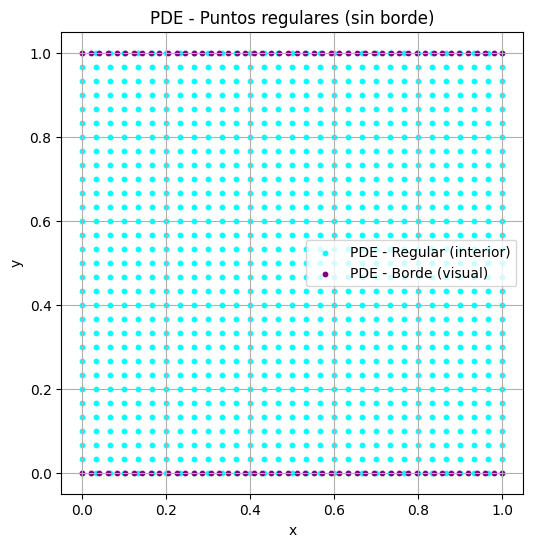

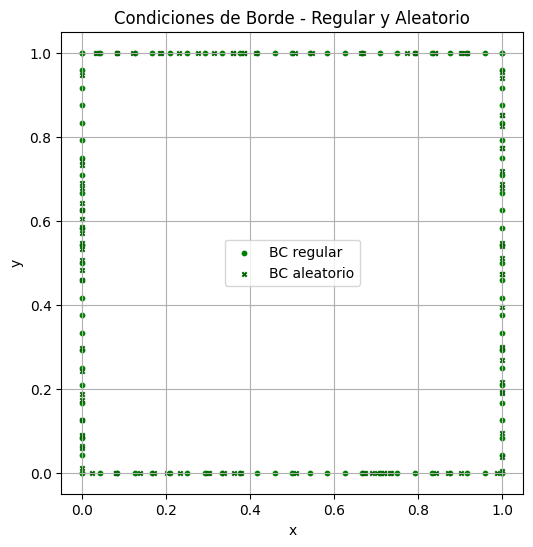

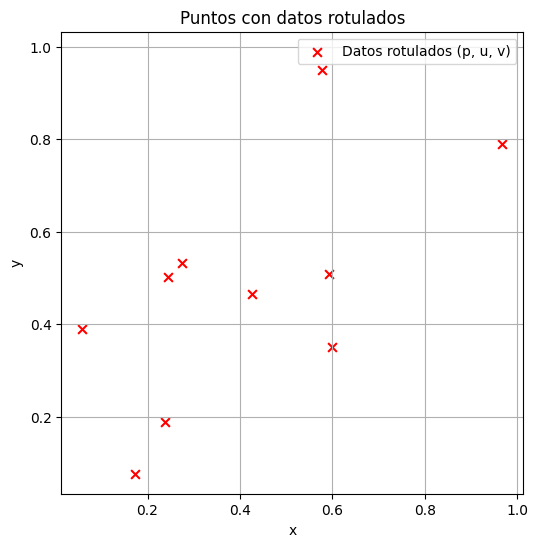


Valores interpolados en puntos rotulados:
     x      y          p          u          v
 0.244  0.501    -0.0061    -0.1685    -0.2286
 0.274  0.532    -0.0029    -0.0832    -0.2446
 0.599  0.350     0.0005    -0.0101     0.0201
 0.059  0.390     0.0057    -0.0212    -0.0125
 0.426  0.465    -0.0528    -0.0016     0.1941
 0.238  0.188    -0.0185    -0.2289    -0.1442
 0.593  0.507     0.0052    -0.0652    -0.0321
 0.172  0.077    -0.0081    -0.1545     0.0616
 0.578  0.950     0.0055    -0.0535    -0.0230
 0.967  0.791    -0.0422     0.4593     0.0434


In [1]:
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/pressure.mat
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/velocity.mat

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Cargar datos
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')

p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']

ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# Parámetro pequeño para evitar bordes en PDE
eps = 1e-5

# Cantidades de puntos
Npde = 1000
Nbc = 100
Ndata = 10
Nbc_per_edge = Nbc // 4

# --- 1. PUNTOS DE COLOCACIÓN PARA PDE ---

x_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)
y_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)

n_side = int(np.sqrt(Npde))
x_grid = np.linspace(eps, 1.0 - eps, n_side)
y_grid = np.linspace(eps, 1.0 - eps, n_side)
x_pde_reg, y_pde_reg = np.meshgrid(x_grid, y_grid)
x_pde_reg = x_pde_reg.flatten()
y_pde_reg = y_pde_reg.flatten()

N_border = 50
x_pde_border = np.linspace(0, 1, N_border)
y_pde_border_top = np.ones(N_border) * 1.0
y_pde_border_bottom = np.zeros(N_border)
x_pde_border_combined = np.concatenate([x_pde_border, x_pde_border])
y_pde_border_combined = np.concatenate([y_pde_border_bottom, y_pde_border_top])

# --- 2. PUNTOS DE COLOCACIÓN PARA BC ---

x_bc_top_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_top_reg = np.ones_like(x_bc_top_reg)
x_bc_bottom_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_bottom_reg = np.zeros_like(x_bc_bottom_reg)
y_bc_left_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_left_reg = np.zeros_like(y_bc_left_reg)
y_bc_right_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_right_reg = np.ones_like(y_bc_right_reg)

x_bc_top_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_top_rand = np.ones_like(x_bc_top_rand)
x_bc_bottom_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_bottom_rand = np.zeros_like(x_bc_bottom_rand)
y_bc_left_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_left_rand = np.zeros_like(y_bc_left_rand)
y_bc_right_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_right_rand = np.ones_like(y_bc_right_rand)

# --- 3. PUNTOS ROTULADOS (mediciones) ---

x_data = np.random.uniform(0, 1, Ndata)
y_data = np.random.uniform(0, 1, Ndata)

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]
    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]
    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]
    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])

# --- GRÁFICAS ---

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_rand, y_pde_rand, s=10, c='blue', label='PDE - Aleatorio (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='navy', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos aleatorios (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_reg, y_pde_reg, s=10, c='cyan', label='PDE - Regular (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='purple', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos regulares (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(np.concatenate([x_bc_top_reg, x_bc_bottom_reg, x_bc_left_reg, x_bc_right_reg]),
            np.concatenate([y_bc_top_reg, y_bc_bottom_reg, y_bc_left_reg, y_bc_right_reg]),
            s=10, c='green', label='BC regular')
plt.scatter(np.concatenate([x_bc_top_rand, x_bc_bottom_rand, x_bc_left_rand, x_bc_right_rand]),
            np.concatenate([y_bc_top_rand, y_bc_bottom_rand, y_bc_left_rand, y_bc_right_rand]),
            s=10, c='darkgreen', marker='x', label='BC aleatorio')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Condiciones de Borde - Regular y Aleatorio')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_data, y_data, s=40, c='red', marker='x', label='Datos rotulados (p, u, v)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos con datos rotulados')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

print("\nValores interpolados en puntos rotulados:")
print(f"{'x':>6} {'y':>6} {'p':>10} {'u':>10} {'v':>10}")
for x, y, p_val, u_val, v_val in zip(x_data, y_data, p_data, u_data, v_data):
    print(f"{x:6.3f} {y:6.3f} {p_val:10.4f} {u_val:10.4f} {v_val:10.4f}")



Los puntos para la PDE no deben incluirse en las fronteras del dominio, ya que las ecuaciones diferenciales se evalúan solo en el interior, mientras que las condiciones de frontera se tratan por separado. Incluir puntos en el borde mezclaría dos tipos de información que deben manejarse con funciones de pérdida distintas.

#TP2


Ep 1000: mom=2.05e-02, cont=1.36e-04, BC=1.36e-02, P0=5.72e-07
Ep 2000: mom=1.89e-02, cont=1.09e-04, BC=1.18e-02, P0=3.05e-02
Ep 3000: mom=1.84e-02, cont=5.46e-05, BC=1.10e-02, P0=2.26e-02
Ep 4000: mom=1.70e-02, cont=1.67e-04, BC=1.07e-02, P0=3.79e-06
Ep 5000: mom=1.97e-02, cont=5.18e-04, BC=1.02e-02, P0=4.78e-05
Ep 6000: mom=1.77e-02, cont=1.04e-04, BC=9.75e-03, P0=5.12e-05
Ep 7000: mom=1.83e-02, cont=1.14e-04, BC=9.21e-03, P0=1.45e-06
Ep 8000: mom=1.81e-02, cont=1.00e-04, BC=8.76e-03, P0=1.87e-06
Ep 9000: mom=1.78e-02, cont=1.07e-04, BC=8.42e-03, P0=1.80e-10
Ep 10000: mom=1.82e-02, cont=6.88e-04, BC=8.28e-03, P0=1.60e-06


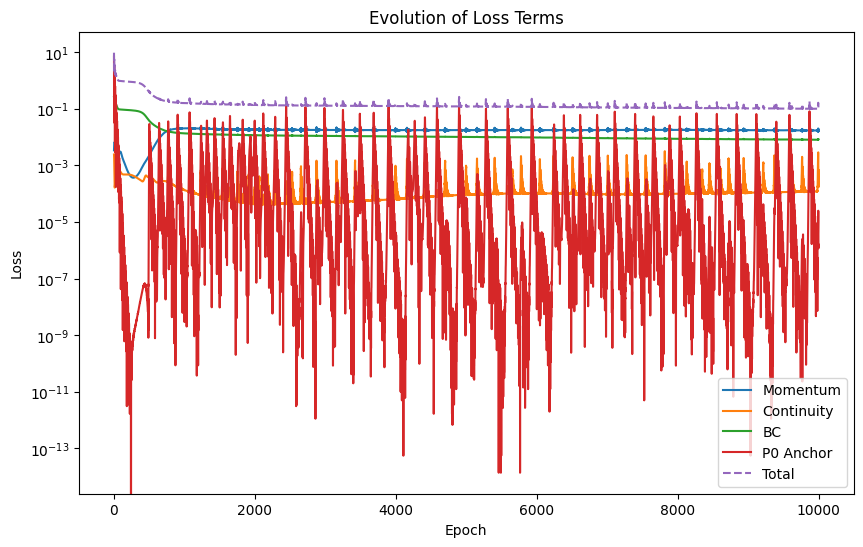

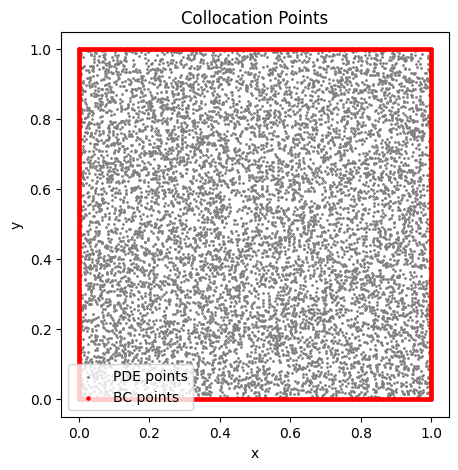

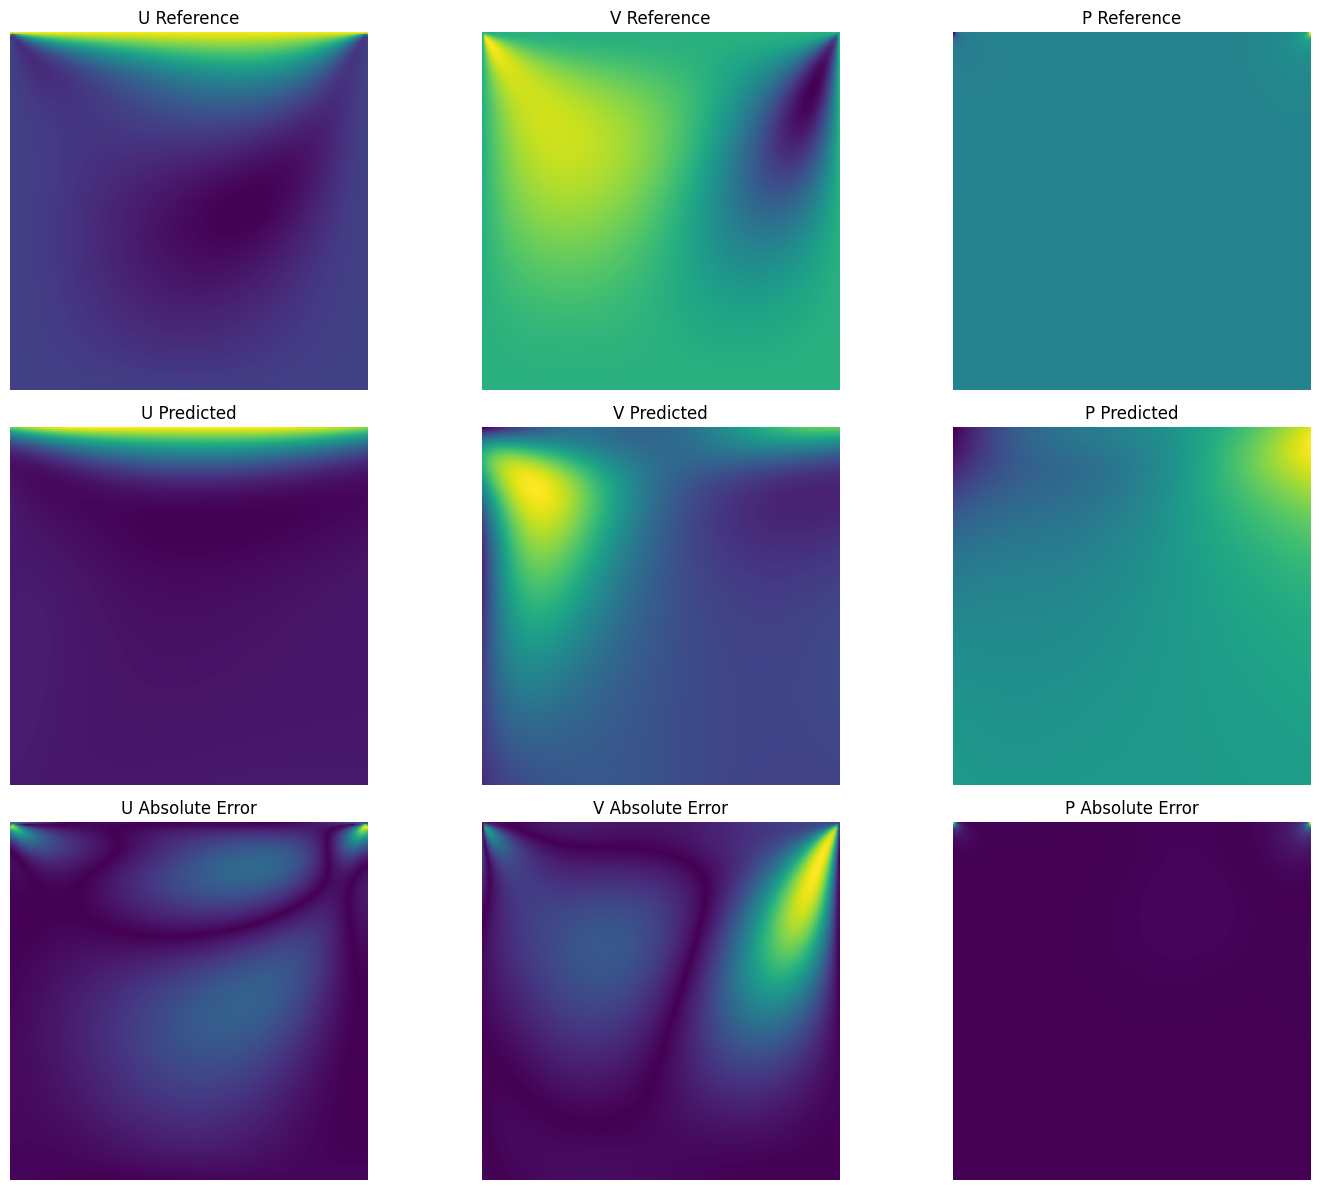

| Variable | L2 Relative Error |
|----------|------------------:|
| u        | 0.4536           |
| v        | 0.8550           |
| p        | 0.8622           |


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import griddata
import torch
import torch.nn as nn
from torch.autograd import grad
from scipy.stats import qmc

# --- TP2 PINN vanilla con gráficas y análisis completos ---
# Arquitectura y hiperparámetros:
#   - Red: FC 4 capas de 50 neuronas, activación Tanh
#   - Re = 100, λ_bc = 10, λ_cont (nuevo), anchor presión = 1e4
#   - Adam lr=1e-3, epochs=10000

# Dispositivo y parámetros
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Re          = 100.0
lambda_bc   = 10.0
lambda_cont = 20.0         # NUEVO: peso para continuidad (reportada por separado)
lambda_p0   = 1e3         #1e4         # Ponderación del ancla p(0,0) ~ 10e3
Npde, Nbc   = 10000, 1000
epochs      = 10000
lr          = 1e-3

# 1. Carga de datos y coordenadas originales
dm    = loadmat('velocity.mat')
x_pts = dm['x'].squeeze()
y_pts = dm['y'].squeeze()
u_pts = dm['u'].squeeze()
v_pts = dm['v'].squeeze()
p_pts = loadmat('pressure.mat')['p'].squeeze()

# 2. Malla regular para interpolación y plots (como sugiere la devolución)
x_unique = np.linspace(x_pts.min(), x_pts.max(), 201)
y_unique = np.linspace(y_pts.min(), y_pts.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)
U_grid = griddata((x_pts, y_pts), u_pts, (X_grid, Y_grid), method='cubic')
V_grid = griddata((x_pts, y_pts), v_pts, (X_grid, Y_grid), method='cubic')
P_grid = griddata((x_pts, y_pts), p_pts, (X_grid, Y_grid), method='cubic')

# 3. Definición de la PINN (igual que tenías)
def make_PINN():
    return nn.Sequential(
        nn.Linear(2, 50), nn.Tanh(),
        nn.Linear(50, 50), nn.Tanh(),
        nn.Linear(50, 50), nn.Tanh(),
        nn.Linear(50, 3)
    )
model = make_PINN().to(device)

# 4. Residuos (momento y continuidad)
def residuals(xy):
    uvp = model(xy)
    u, v, p = uvp[:,0:1], uvp[:,1:2], uvp[:,2:3]
    def grads(f):
        return grad(f, xy, grad_outputs=torch.ones_like(f), create_graph=True)[0]
    u_x, u_y = grads(u).split(1,1)
    v_x, v_y = grads(v).split(1,1)
    p_x, p_y = grads(p).split(1,1)
    u_xx = grads(u_x).split(1,1)[0]; u_yy = grads(u_y).split(1,1)[1]
    v_xx = grads(v_x).split(1,1)[0]; v_yy = grads(v_y).split(1,1)[1]
    res_x = u*u_x + v*u_y + p_x - (1/Re)*(u_xx + u_yy)
    res_y = u*v_x + v*v_y + p_y - (1/Re)*(v_xx + v_yy)
    cont  = u_x + v_y
    return res_x, res_y, cont

# 5. Muestreo de collocation y condiciones de contorno (tu lógica original)
torch.manual_seed(0)
xy_pde = torch.rand(Npde, 2, device=device, requires_grad=True)

def sample_bc(N):
    per = N // 4
    xs = torch.linspace(0,1,per, device=device)
    b  = torch.stack([xs, torch.zeros_like(xs)],1)
    t  = torch.stack([xs, torch.ones_like(xs)],1)
    ys = xs.clone()
    l  = torch.stack([torch.zeros_like(ys), ys],1)
    r  = torch.stack([torch.ones_like(ys), ys],1)
    return torch.cat([b, t, l, r],0)[:N]
xy_bc   = sample_bc(Nbc)
ubc     = torch.zeros(Nbc,1, device=device)
vbc     = torch.zeros_like(ubc)
mask    = xy_bc[:,1] == 1.0
ubc[mask,0] = 1.0

# 6. Anclaje de presión en (0,0)
xy_p0     = torch.tensor([[0.0,0.0]], device=device)
p0_target = torch.tensor([[0.0]], device=device)

# 7. Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Listas de seguimiento de pérdidas
loss_mom_list, loss_cont_list = [], []
loss_bc_list, loss_p0_list, loss_tot_list = [], [], []

# 8. Bucle de entrenamiento
for ep in range(1, epochs+1):
    optimizer.zero_grad()

    rx, ry, rc = residuals(xy_pde)
    loss_mom  = (rx**2 + ry**2).mean()     # residuo de momento (x,y)
    loss_cont = (rc**2).mean()             # continuidad por separado (como pidieron)

    uvb       = model(xy_bc)
    loss_bc   = ((uvb[:,0:1] - ubc)**2 + (uvb[:,1:2] - vbc)**2).mean()

    p0_pred   = model(xy_p0)[:,2:3]
    loss_p0   = lambda_p0 * (p0_pred - p0_target).pow(2).mean()

    # Cambio mínimo: continuidad con su propio peso
    loss_total = loss_mom + lambda_cont*loss_cont + lambda_bc * loss_bc + loss_p0

    loss_total.backward()
    optimizer.step()

    # Guardar pérdidas
    loss_mom_list.append(loss_mom.item())
    loss_cont_list.append(loss_cont.item())
    loss_bc_list.append(loss_bc.item())
    loss_p0_list.append(loss_p0.item())
    loss_tot_list.append(loss_total.item())

    if ep % 1000 == 0:
        print(f"Ep {ep}: mom={loss_mom:.2e}, cont={loss_cont:.2e}, BC={loss_bc:.2e}, P0={loss_p0:.2e}")

# 9. Evolución de pérdidas
plt.figure(figsize=(10,6))
plt.plot(loss_mom_list, label='Momentum')
plt.plot(loss_cont_list, label='Continuity')
plt.plot(loss_bc_list, label='BC')
plt.plot(loss_p0_list, label='P0 Anchor')
plt.plot(loss_tot_list, label='Total', linestyle='--')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Evolution of Loss Terms'); plt.show()

# 10. Scatter de puntos PDE vs BC
plt.figure(figsize=(5,5))
xy_pde_np = xy_pde.detach().cpu().numpy()
xy_bc_np  = xy_bc.detach().cpu().numpy()
plt.scatter(xy_pde_np[:,0], xy_pde_np[:,1], s=1, c='gray', label='PDE points')
plt.scatter(xy_bc_np[:,0], xy_bc_np[:,1], s=5, c='red', label='BC points')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.title('Collocation Points'); plt.show()

# 11. Evaluación en grilla y mapas de error (usando la grilla interpolada)
pts = torch.tensor(np.vstack([X_grid.ravel(), Y_grid.ravel()]).T,
                   dtype=torch.float32, device=device)
with torch.no_grad():
    pred_uvp = model(pts).cpu().numpy()
U_pred = pred_uvp[:,0].reshape(X_grid.shape)
V_pred = pred_uvp[:,1].reshape(X_grid.shape)
P_pred = pred_uvp[:,2].reshape(X_grid.shape)

fig, axs = plt.subplots(3,3, figsize=(15,12))
for i,(ref,pred,title) in enumerate(zip([U_grid, V_grid, P_grid],
                                       [U_pred, V_pred, P_pred],
                                       ['U','V','P'])):
    axs[0,i].imshow(ref, origin='lower', extent=[x_pts.min(), x_pts.max(), y_pts.min(), y_pts.max()])
    axs[0,i].set_title(f'{title} Reference')
    axs[1,i].imshow(pred, origin='lower', extent=[x_pts.min(), x_pts.max(), y_pts.min(), y_pts.max()])
    axs[1,i].set_title(f'{title} Predicted')
    axs[2,i].imshow(np.abs(pred-ref), origin='lower', extent=[x_pts.min(), x_pts.max(), y_pts.min(), y_pts.max()])
    axs[2,i].set_title(f'{title} Absolute Error')
    for ax in axs[:,i]: ax.axis('off')
plt.tight_layout(); plt.show()

# 12. Tabla de errores L2 relativos (sobre la misma grilla)
mask = ~np.isnan(U_grid)
err_u = np.linalg.norm(U_pred[mask]-U_grid[mask]) / np.linalg.norm(U_grid[mask])
mask = ~np.isnan(V_grid)
err_v = np.linalg.norm(V_pred[mask]-V_grid[mask]) / np.linalg.norm(V_grid[mask])
mask = ~np.isnan(P_grid)
err_p = np.linalg.norm(P_pred[mask]-P_grid[mask]) / np.linalg.norm(P_grid[mask])
print('| Variable | L2 Relative Error |')
print('|----------|------------------:|')
print(f"| u        | {err_u:.4f}           |")
print(f"| v        | {err_v:.4f}           |")
print(f"| p        | {err_p:.4f}           |")


## PUNTO 5

El modelo es aceptable para un primer nivel de predicción, útil para capturar tendencias globales del flujo y de la presión, pero aún no es lo suficientemente preciso para reemplazar la solución numérica en aplicaciones donde se requiera exactitud cuantitativa. Con los ajustes propuestos, especialmente refinamiento de puntos y optimización adicional, se espera mejorar tanto las métricas como el cumplimiento local de la física.

## TP3

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import griddata
from scipy.stats import qmc
import torch
import torch.nn as nn
from torch.autograd import grad
from collections import defaultdict
import time

# -------------------------
# Configuración general
# -------------------------
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED          = 0
torch.manual_seed(SEED); np.random.seed(SEED)

# Hiperparámetros (idénticos para las 9 corridas, como exige TP3)
Re            = 100.0
lambda_bc     = 10.0       # indicado por el enunciado TP3
lambda_cont   = 20.0       # usamos el mismo de TP2
lambda_p0     = 1e3
lambda_pmean  = 0.5        # gauge suave
EPOCHS        = 10000
LR            = 1e-3
EPS           = 1e-3
RESAMPLE_EVERY = 200       # para RANDOM/LHS
GRAD_CLIP     = 1.0

# RAD (residual-based adaptive distribution)
USE_RAD               = True
RAD_UPDATE_EVERY      = 300    # cada cuántas épocas actualizamos PDF y re-sampleamos PDE
POOL_PDE              = 50000  # tamaño del pool donde estimamos residuo
RAD_K                 = 1.0    # prob ∝ (residuo)^k
RAD_EPS_PDF           = 1e-12  # para estabilidad
RAD_PDF_CLIP_MAX      = None   # o un valor como 1e2 si querés recortar outliers

# Tamaños pedidos por el TP3
DATASETS = [
    (1_000, 100),
    (10_000, 1_000),
    (100_000, 10_000),
]

# Estrategias
STRATEGIES = ["RANDOM", "LHS", "RAD"]

# -------------------------
# Cargar dataset (ground-truth)
# -------------------------
dm    = loadmat('velocity.mat')
x_pts = dm['x'].squeeze()
y_pts = dm['y'].squeeze()
u_pts = dm['u'].squeeze()
v_pts = dm['v'].squeeze()
p_pts = loadmat('pressure.mat')['p'].squeeze()

# Grilla regular para comparar y graficar
x_unique = np.linspace(x_pts.min(), x_pts.max(), 201)
y_unique = np.linspace(y_pts.min(), y_pts.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)
U_grid = griddata((x_pts, y_pts), u_pts, (X_grid, Y_grid), method='cubic')
V_grid = griddata((x_pts, y_pts), v_pts, (X_grid, Y_grid), method='cubic')
P_grid = griddata((x_pts, y_pts), p_pts, (X_grid, Y_grid), method='cubic')

grid_pts_torch = torch.tensor(
    np.vstack([X_grid.ravel(), Y_grid.ravel()]).T,
    dtype=torch.float32, device=device
)

# -------------------------
# Modelo
# -------------------------
def make_PINN():
    return nn.Sequential(
        nn.Linear(2, 50), nn.Tanh(),
        nn.Linear(50, 50), nn.Tanh(),
        nn.Linear(50, 50), nn.Tanh(),
        nn.Linear(50, 3)
    )

def residuals(model, xy):
    uvp = model(xy)
    u, v, p = uvp[:,0:1], uvp[:,1:2], uvp[:,2:3]
    def grads(f):
        return grad(f, xy, grad_outputs=torch.ones_like(f), create_graph=True)[0]
    u_x, u_y = grads(u).split(1,1)
    v_x, v_y = grads(v).split(1,1)
    p_x, p_y = grads(p).split(1,1)
    u_xx = grads(u_x).split(1,1)[0]; u_yy = grads(u_y).split(1,1)[1]
    v_xx = grads(v_x).split(1,1)[0]; v_yy = grads(v_y).split(1,1)[1]
    res_x = u*u_x + v*u_y + p_x - (1/Re)*(u_xx + u_yy)
    res_y = u*v_x + v*v_y + p_y - (1/Re)*(v_xx + v_yy)
    cont  = u_x + v_y
    return res_x, res_y, cont

# -------------------------
# Muestreos de PDE
# -------------------------
def sample_pde_random(N):
    xy = torch.rand(N, 2, device=device)
    xy.requires_grad_(True)
    return xy

def sample_pde_lhs(N):
    sampler = qmc.LatinHypercube(d=2, seed=SEED)
    pts = sampler.random(N)
    xy = torch.tensor(pts, dtype=torch.float32, device=device)
    xy.requires_grad_(True)
    return xy

@torch.no_grad()
def build_pdf_from_residual(model, pool_xy):
    # residuo total = sqrt(rx^2 + ry^2) + |cont|
    rx, ry, rc = residuals(model, pool_xy)
    res = torch.sqrt(rx**2 + ry**2) + torch.abs(rc)
    res = res.detach().flatten()
    res = res - res.min()
    res = res + RAD_EPS_PDF
    if RAD_K != 1.0:
        res = res**RAD_K
    if RAD_PDF_CLIP_MAX is not None:
        res = torch.clamp(res, max=RAD_PDF_CLIP_MAX)
    pdf = res / res.sum()
    return pdf.cpu().numpy()

def sample_pde_rad(model, N, pool_size=POOL_PDE):
    # construimos un pool uniforme (o LHS) y muestreamos según pdf ∝ residuo
    pool_xy = torch.rand(pool_size, 2, device=device, requires_grad=True)
    pdf = build_pdf_from_residual(model, pool_xy)
    idx = np.random.choice(pool_size, size=N, replace=False, p=pdf)
    xy = pool_xy[idx]
    xy.requires_grad_(True)
    return xy

def sample_pde(strategy, N, model_for_rad=None):
    if strategy == "RANDOM":
        return sample_pde_random(N)
    elif strategy == "LHS":
        return sample_pde_lhs(N)
    elif strategy == "RAD":
        # para el primer muestreo, no hay modelo entrenado: usamos random (warm start)
        if model_for_rad is None:
            return sample_pde_random(N)
        else:
            return sample_pde_rad(model_for_rad, N)
    else:
        raise ValueError("Estrategia desconocida")

# -------------------------
# Muestreo de BC (misma idea que ajustamos en TP2)
# -------------------------
def sample_bc(N):
    per = N // 4
    # bottom y=0
    xb = torch.rand(per,1,device=device)*(1-2*EPS)+EPS
    b  = torch.cat([xb, torch.zeros_like(xb)], dim=1)
    # top y=1
    xt = torch.rand(per,1,device=device)*(1-2*EPS)+EPS
    t  = torch.cat([xt, torch.ones_like(xt)], dim=1)
    # left x=0
    yl = torch.rand(per,1,device=device)*(1-2*EPS)+EPS
    l  = torch.cat([torch.zeros_like(yl), yl], dim=1)
    # right x=1
    yr = torch.rand(per,1,device=device)*(1-2*EPS)+EPS
    r  = torch.cat([torch.ones_like(yr), yr], dim=1)
    xy_bc = torch.cat([b, t, l, r], 0)
    ubc   = torch.zeros(xy_bc.shape[0],1, device=device)
    vbc   = torch.zeros_like(ubc)
    mask  = (xy_bc[:,1] == 1.0)
    ubc[mask,0] = 1.0
    return xy_bc, ubc, vbc

# -------------------------
# Entrenamiento y evaluación
# -------------------------
def train_one_config(strategy, Npde, Nbc, epochs=EPOCHS, lr=LR):
    model = make_PINN().to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    # datasets iniciales
    xy_pde = sample_pde(strategy, Npde, None)
    xy_bc, ubc, vbc = sample_bc(Nbc)

    xy_p0     = torch.tensor([[0.0,0.0]], device=device)
    p0_target = torch.tensor([[0.0]], device=device)

    t0 = time.time()
    for ep in range(1, epochs+1):
        opt.zero_grad()
        rx, ry, rc = residuals(model, xy_pde)
        loss_mom   = (rx**2 + ry**2).mean()
        loss_cont  = (rc**2).mean()

        uvb        = model(xy_bc)
        loss_bc    = ((uvb[:,0:1]-ubc)**2 + (uvb[:,1:2]-vbc)**2).mean()

        # gauge presión suave (media ~ 0 en batch interior)
        with torch.no_grad():
            p_in = model(xy_pde)[:,2:3]
        loss_pmean = (p_in.mean())**2 * lambda_pmean

        p0_pred    = model(xy_p0)[:,2:3]
        loss_p0    = lambda_p0 * (p0_pred - p0_target).pow(2).mean()

        loss_total = loss_mom + lambda_cont*loss_cont + lambda_bc*loss_bc + loss_pmean + loss_p0
        loss_total.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        opt.step()

        # Re-muestreos
        if strategy in ["RANDOM", "LHS"]:
            if ep % RESAMPLE_EVERY == 0:
                xy_pde = sample_pde(strategy, Npde, None)
                xy_bc, ubc, vbc = sample_bc(Nbc)
        elif strategy == "RAD":
            if ep % RAD_UPDATE_EVERY == 0:
                # rearmamos PDE en función de residuo del modelo actual
                xy_pde = sample_pde("RAD", Npde, model)
                xy_bc, ubc, vbc = sample_bc(Nbc)

        if ep % 1000 == 0:
            print(f"[{strategy} Npde={Npde} Nbc={Nbc}] Ep {ep}: "
                  f"mom={loss_mom.item():.2e}, cont={loss_cont.item():.2e}, "
                  f"BC={loss_bc.item():.2e}, Pmean={loss_pmean.item():.2e}, P0={loss_p0.item():.2e}")

    t1 = time.time()
    dt = t1 - t0

    # Evaluación en grilla
    with torch.no_grad():
        pred = model(grid_pts_torch).cpu().numpy()
    U_pred = pred[:,0].reshape(X_grid.shape)
    V_pred = pred[:,1].reshape(X_grid.shape)
    P_pred = pred[:,2].reshape(X_grid.shape)

    # Errores L2 relativos
    mask = ~np.isnan(U_grid)
    err_u = np.linalg.norm(U_pred[mask]-U_grid[mask]) / np.linalg.norm(U_grid[mask])
    mask = ~np.isnan(V_grid)
    err_v = np.linalg.norm(V_pred[mask]-V_grid[mask]) / np.linalg.norm(V_grid[mask])
    mask = ~np.isnan(P_grid)
    err_p = np.linalg.norm(P_pred[mask]-P_grid[mask]) / np.linalg.norm(P_grid[mask])

    return {
        "model": model,
        "U_pred": U_pred, "V_pred": V_pred, "P_pred": P_pred,
        "err_u": err_u, "err_v": err_v, "err_p": err_p,
        "train_time_s": dt
    }

# -------------------------
# Experimento TP3
# -------------------------
results = defaultdict(dict)

for strategy in STRATEGIES:
    for (Npde, Nbc) in DATASETS:
        print(f"\n=== Training: {strategy} | Npde={Npde}, Nbc={Nbc} ===")
        out = train_one_config(strategy, Npde, Nbc)
        results[strategy][Npde] = out
        print(f"Done: {strategy} Npde={Npde} | "
              f"L2(u)={out['err_u']:.4f}, L2(v)={out['err_v']:.4f}, L2(p)={out['err_p']:.4f} | "
              f"time={out['train_time_s']:.1f}s")

# -------------------------
# Plots de convergencia (loglog)
# -------------------------
def plot_convergence(metric_key, title):
    plt.figure(figsize=(6,4.5))
    for strategy in STRATEGIES:
        xs = sorted(results[strategy].keys())
        ys = [results[strategy][n][metric_key] for n in xs]
        plt.loglog(xs, ys, marker='o', label=strategy)
    plt.xlabel('Npde (tamaño dataset PDE)')
    plt.ylabel(f'{metric_key} (L2)')
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.show()

plot_convergence("err_u", "Convergencia L2(u) vs Npde")
plot_convergence("err_v", "Convergencia L2(v) vs Npde")
plot_convergence("err_p", "Convergencia L2(p) vs Npde")

# -------------------------
# Tabla resumen (en consola)
# -------------------------
print("\n=== Resumen TP3 (L2 errors) ===")
for strategy in STRATEGIES:
    for Npde in sorted(results[strategy].keys()):
        r = results[strategy][Npde]
        print(f"{strategy:6s} | Npde={Npde:6d} | L2(u)={r['err_u']:.4f} | L2(v)={r['err_v']:.4f} | L2(p)={r['err_p']:.4f} | time={r['train_time_s']:.1f}s")



=== Training: RANDOM | Npde=1000, Nbc=100 ===
[RANDOM Npde=1000 Nbc=100] Ep 1000: mom=2.99e-03, cont=2.28e-04, BC=3.48e-02, Pmean=1.69e-04, P0=6.68e-03
[RANDOM Npde=1000 Nbc=100] Ep 2000: mom=2.02e-02, cont=7.92e-05, BC=1.37e-02, Pmean=1.49e-04, P0=6.65e-03
[RANDOM Npde=1000 Nbc=100] Ep 3000: mom=1.67e-02, cont=2.43e-05, BC=7.56e-03, Pmean=2.89e-05, P0=1.36e-03
[RANDOM Npde=1000 Nbc=100] Ep 4000: mom=1.80e-02, cont=5.04e-05, BC=4.64e-03, Pmean=4.99e-07, P0=2.17e-03
[RANDOM Npde=1000 Nbc=100] Ep 5000: mom=1.44e-02, cont=5.12e-04, BC=9.18e-03, Pmean=5.25e-06, P0=2.57e-03
[RANDOM Npde=1000 Nbc=100] Ep 6000: mom=1.74e-02, cont=3.36e-05, BC=4.85e-03, Pmean=1.28e-06, P0=1.39e-02
[RANDOM Npde=1000 Nbc=100] Ep 7000: mom=1.73e-02, cont=1.98e-05, BC=5.75e-03, Pmean=1.76e-05, P0=7.79e-04
[RANDOM Npde=1000 Nbc=100] Ep 8000: mom=2.44e-02, cont=3.41e-05, BC=1.31e-02, Pmean=8.33e-05, P0=1.83e-03
[RANDOM Npde=1000 Nbc=100] Ep 9000: mom=2.06e-02, cont=2.37e-05, BC=9.84e-03, Pmean=5.00e-05, P0=1.86e-03

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## TP4


In [8]:

import numpy as np
from scipy.io import loadmat
from scipy.interpolate import griddata
from scipy.stats import qmc
import torch
import torch.nn as nn
from torch.autograd import grad
import time

# =========================
# Configuración
# =========================
CONFIG = {
    "seed": 0,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "epochs": 12000,              # 12k-15k recomendado
    "lr": 1e-3,
    "Npde": 10000,
    "Nbc": 1000,
    "lambda": {
        "bc": 10.0,
        "cont": 20.0,
        "data": 5.0,
        "p0": 1e3,
        "pmean": 0.2,
        "Re_prior": 5e-2,   # antes 1e-2
        "data_u": 2.0,      # guía más con u
        "data_v": 0.0,      # TP4 pide u y p (no v)
        "data_p": 1.0,
    },
    "grad_clip": 1.0,
    "eps_bc": 1e-3,               # evita esquinas exactas
    "log_every": 500,
    "true_Re_for_reference": 100.0,
    "grid_eval_res": 201,
    "RESAMPLE_EVERY": 500,        # re-muestreo LHS de PDE/BC
    # rango plausible para R
    "Re_min": 90.0,     # antes 50 ó 80
    "Re_max": 140.0,    # antes 180 ó 300

}

# =========================
# Utils
# =========================
def set_seed(seed):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def lhs_sample(n, d, seed=None):
    sampler = qmc.LatinHypercube(d=d, seed=seed)
    return sampler.random(n).astype(np.float32)

def build_fc(in_dim=2, hidden=50, depth=3, out_dim=3, act=nn.Tanh):
    layers = [nn.Linear(in_dim, hidden), act()]
    for _ in range(depth-1):
        layers += [nn.Linear(hidden, hidden), act()]
    layers += [nn.Linear(hidden, out_dim)]
    m = nn.Sequential(*layers)
    # init Xavier para estabilidad
    for layer in m:
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
    return m

def residuals(model, xy, Re_val):
    """
    NS 2D estacionario, incomprensible:
      res_x = u*u_x + v*u_y + p_x - (1/Re)(u_xx + u_yy)
      res_y = u*v_x + v*v_y + p_y - (1/Re)(v_xx + v_yy)
      cont  = u_x + v_y
    """
    uvp = model(xy)
    u, v, p = uvp[:,0:1], uvp[:,1:2], uvp[:,2:3]

    def grads(f):
        return grad(f, xy, grad_outputs=torch.ones_like(f), create_graph=True)[0]

    u_x, u_y = grads(u).split(1,1)
    v_x, v_y = grads(v).split(1,1)
    p_x, p_y = grads(p).split(1,1)

    u_xx = grads(u_x).split(1,1)[0]; u_yy = grads(u_y).split(1,1)[1]
    v_xx = grads(v_x).split(1,1)[0]; v_yy = grads(v_y).split(1,1)[1]

    invRe = 1.0 / Re_val
    res_x = u*u_x + v*u_y + p_x - invRe*(u_xx + u_yy)
    res_y = u*v_x + v*v_y + p_y - invRe*(v_xx + v_yy)
    cont  = u_x + v_y
    return res_x, res_y, cont

def sample_bc(N, device, eps=1e-3):
    """Muestreo en cuatro paredes evitando esquinas exactas."""
    per = N // 4
    # bottom y=0
    xb = torch.rand(per,1,device=device)*(1-2*eps)+eps
    b  = torch.cat([xb, torch.zeros_like(xb)], dim=1)
    # top y=1
    xt = torch.rand(per,1,device=device)*(1-2*eps)+eps
    t  = torch.cat([xt, torch.ones_like(xt)], dim=1)
    # left x=0
    yl = torch.rand(per,1,device=device)*(1-2*eps)+eps
    l  = torch.cat([torch.zeros_like(yl), yl], dim=1)
    # right x=1
    yr = torch.rand(per,1,device=device)*(1-2*eps)+eps
    r  = torch.cat([torch.ones_like(yr), yr], dim=1)
    xy_bc = torch.cat([b, t, l, r], 0)

    ubc   = torch.zeros(xy_bc.shape[0],1, device=device)
    vbc   = torch.zeros_like(ubc)
    # tapa móvil: u=1 en y=1 (exactamente 1.0 por construcción)
    mask  = (xy_bc[:,1] == 1.0)
    ubc[mask,0] = 1.0
    return xy_bc, ubc, vbc

def make_centered_square_points(side, nx, ny):
    """Devuelve (x,y) en un cuadrado centrado de lado 'side' en [0,1]^2."""
    x0 = 0.5 - side/2.0; x1 = 0.5 + side/2.0
    y0 = 0.5 - side/2.0; y1 = 0.5 + side/2.0
    xs = np.linspace(x0, x1, nx, dtype=np.float32)
    ys = np.linspace(y0, y1, ny, dtype=np.float32)
    X, Y = np.meshgrid(xs, ys)
    return np.vstack([X.ravel(), Y.ravel()]).T

def interpolate_fields_to(points_xy, x, y, U, V, P):
    Uq = griddata((x, y), U, (points_xy[:,0], points_xy[:,1]), method="cubic")
    Vq = griddata((x, y), V, (points_xy[:,0], points_xy[:,1]), method="cubic")
    Pq = griddata((x, y), P, (points_xy[:,0], points_xy[:,1]), method="cubic")
    return Uq, Vq, Pq

def add_white_noise(arr, frac):
    if frac <= 0: return arr
    scale = np.nanmax(np.abs(arr))
    if not np.isfinite(scale) or scale == 0:
        return arr
    noise = np.random.randn(*arr.shape).astype(np.float32) * (frac * scale)
    return arr + noise

def relative_L2(pred, ref):
    mask = np.isfinite(ref)
    if not np.any(mask):
        return np.nan
    num = np.linalg.norm(pred[mask] - ref[mask])
    den = np.linalg.norm(ref[mask])
    return num/den if den > 0 else np.nan

def load_dataset():
    dm = loadmat('velocity.mat')
    x = dm['x'].squeeze().astype(np.float32)
    y = dm['y'].squeeze().astype(np.float32)
    U = dm['u'].squeeze().astype(np.float32)
    V = dm['v'].squeeze().astype(np.float32)
    P = loadmat('pressure.mat')['p'].squeeze().astype(np.float32)
    return x, y, U, V, P

def build_eval_grid(x, y, U, V, P, res=201):
    xs = np.linspace(np.min(x), np.max(x), res, dtype=np.float32)
    ys = np.linspace(np.min(y), np.max(y), res, dtype=np.float32)
    Xg, Yg = np.meshgrid(xs, ys)
    Ug = griddata((x, y), U, (Xg, Yg), method='cubic')
    Vg = griddata((x, y), V, (Xg, Yg), method='cubic')
    Pg = griddata((x, y), P, (Xg, Yg), method='cubic')
    pts = np.vstack([Xg.ravel(), Yg.ravel()]).T.astype(np.float32)
    return Xg, Yg, Ug, Vg, Pg, pts

# =========================
# Entrenamiento de un experimento (lado/ruido)
# =========================
def run_one_experiment(side_len, noise_frac, config=CONFIG):
    set_seed(config["seed"])
    device = torch.device(config["device"])
    x, y, U, V, P = load_dataset()
    Xg, Yg, Ug, Vg, Pg, eval_pts = build_eval_grid(x, y, U, V, P, res=config["grid_eval_res"])

    # stds para normalizar loss de datos
    u_std = float(np.nanstd(U)); v_std = float(np.nanstd(V)); p_std = float(np.nanstd(P))
    u_std = u_std if u_std > 0 else 1.0
    v_std = v_std if v_std > 0 else 1.0
    p_std = p_std if p_std > 0 else 1.0

    # Datos rotulados: 5x5 dentro de un cuadrado centrado
    data_xy = make_centered_square_points(side_len, 5, 5).astype(np.float32)
    U_data, V_data, P_data = interpolate_fields_to(data_xy, x, y, U, V, P)
    # fallback nearest si cubic deja NaNs en bordes
    if np.any(~np.isfinite(U_data)) or np.any(~np.isfinite(V_data)) or np.any(~np.isfinite(P_data)):
        U_data_n = griddata((x,y), U, (data_xy[:,0], data_xy[:,1]), method='nearest')
        V_data_n = griddata((x,y), V, (data_xy[:,0], data_xy[:,1]), method='nearest')
        P_data_n = griddata((x,y), P, (data_xy[:,0], data_xy[:,1]), method='nearest')
        U_data = np.where(np.isfinite(U_data), U_data, U_data_n)
        V_data = np.where(np.isfinite(V_data), V_data, V_data_n)
        P_data = np.where(np.isfinite(P_data), P_data, P_data_n)

    # Añadir ruido
    U_lab = add_white_noise(U_data.astype(np.float32), noise_frac)
    V_lab = add_white_noise(V_data.astype(np.float32), noise_frac)
    P_lab = add_white_noise(P_data.astype(np.float32), noise_frac)

    xy_data_t = torch.tensor(data_xy, dtype=torch.float32, device=device)
    U_lab_t   = torch.tensor(U_lab.reshape(-1,1), dtype=torch.float32, device=device)
    V_lab_t   = torch.tensor(V_lab.reshape(-1,1), dtype=torch.float32, device=device)
    P_lab_t   = torch.tensor(P_lab.reshape(-1,1), dtype=torch.float32, device=device)

    # PDE interior LHS
    xy_pde = lhs_sample(config["Npde"], 2, seed=config["seed"])
    xy_pde_t = torch.tensor(xy_pde, dtype=torch.float32, device=device, requires_grad=True)
    # BC
    xy_bc_t, ubc_t, vbc_t = sample_bc(config["Nbc"], device, eps=config["eps_bc"])

    # Modelo
    model = build_fc(in_dim=2, hidden=50, depth=3, out_dim=3, act=nn.Tanh).to(device)

    # Parámetro Re acotado vía sigmoide: Re = Re_min + (Re_max-Re_min)*sigmoid(theta)
    Re_min, Re_max = config["Re_min"], config["Re_max"]
    theta = nn.Parameter(torch.tensor([0.0], dtype=torch.float32, device=device))
    def Re_from_theta(theta):
        sig = torch.sigmoid(theta)
        return Re_min + (Re_max - Re_min) * sig

    params = list(model.parameters()) + [theta]
    opt = torch.optim.Adam(params, lr=config["lr"])
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10, verbose=False)

    # Gauges de presión
    xy_p0     = torch.tensor([[0.0,0.0]], dtype=torch.float32, device=device)
    p0_target = torch.tensor([[0.0]], dtype=torch.float32, device=device)

    lam = config["lambda"]
    Re_prior_val = torch.tensor([config["true_Re_for_reference"]], dtype=torch.float32, device=device)

    t0 = time.time()
    for ep in range(1, config["epochs"]+1):
        opt.zero_grad()

        Re_val = Re_from_theta(theta)

        # Residuos PDE/cont
        rx, ry, rc = residuals(model, xy_pde_t, Re_val)
        loss_mom   = (rx**2 + ry**2).mean()
        loss_cont  = (rc**2).mean()

        # BC
        uvb      = model(xy_bc_t)
        loss_bc  = ((uvb[:,0:1]-ubc_t)**2 + (uvb[:,1:2]-vbc_t)**2).mean()

        # Datos rotulados (normalizados por escala)
        uvpd = model(xy_data_t)
        loss_data = (
            CONFIG["lambda"]["data_u"]*((uvpd[:,0:1]-U_lab_t)/u_std).pow(2) +
            CONFIG["lambda"]["data_p"]*((uvpd[:,2:3]-P_lab_t)/p_std).pow(2)
        ).mean()
        loss_data = CONFIG["lambda"]["data"] * loss_data


        # Gauges presión
        p0_pred  = model(xy_p0)[:,2:3]
        loss_p0  = lam["p0"] * (p0_pred - p0_target).pow(2).mean()

        p_in     = model(xy_pde_t)[:,2:3]
        loss_pmean = lam["pmean"] * (p_in.mean())**2

        # Prior suave en Re (en log-space para escalar mejor)
        loss_Reprior = lam["Re_prior"] * (torch.log(Re_val) - torch.log(Re_prior_val)).pow(2).mean()

        loss_total = (loss_mom + lam["cont"]*loss_cont + lam["bc"]*loss_bc
                      + loss_data + loss_p0 + loss_pmean + loss_Reprior)

        loss_total.backward()
        torch.nn.utils.clip_grad_norm_(params, config["grad_clip"])
        opt.step()
        sched.step(loss_total.detach())

        # Re-muestreo periódico de PDE y BC
        if ep % config["RESAMPLE_EVERY"] == 0:
            xy_pde = lhs_sample(config["Npde"], 2, seed=config["seed"] + ep)
            xy_pde_t = torch.tensor(xy_pde, dtype=torch.float32, device=device, requires_grad=True)
            xy_bc_t, ubc_t, vbc_t = sample_bc(config["Nbc"], device, eps=config["eps_bc"])

        if ep % config["log_every"] == 0 or ep == 1:
            print(f"Ep {ep:5d} | Loss {loss_total.item():.3e} | mom {loss_mom.item():.3e} "
                  f"| cont {loss_cont.item():.3e} | bc {loss_bc.item():.3e} | data {loss_data.item():.3e} "
                  f"| Re {float(Re_val.item()):.3f}")

    t1 = time.time()
    train_time = t1 - t0

    # Evaluación en grilla
    eval_pts_t = torch.tensor(eval_pts, dtype=torch.float32, device=device)
    with torch.no_grad():
        pred = model(eval_pts_t).cpu().numpy()
        Re_est = float(Re_from_theta(theta).detach().cpu().item())

    U_pred = pred[:,0].reshape(Xg.shape)
    V_pred = pred[:,1].reshape(Xg.shape)
    P_pred = pred[:,2].reshape(Xg.shape)

    err_u = relative_L2(U_pred, Ug)
    err_v = relative_L2(V_pred, Vg)
    err_p = relative_L2(P_pred, Pg)

    return {
        "side": side_len,
        "noise": noise_frac,
        "Re_est": Re_est,
        "err_u": float(err_u),
        "err_v": float(err_v),
        "err_p": float(err_p),
        "train_time_s": float(train_time),
        "epochs": config["epochs"]
    }

# =========================
# Main
# =========================
def main():
    set_seed(CONFIG["seed"])
    sides  = [0.25, 0.50, 0.75]
    noises = [0.0, 1e-4]  # 0% y 0.01%

    results = []
    for s in sides:
        for n in noises:
            print("\n==============================")
            print(f"Running TP4 inverse (stabilized): side={s:.2f}, noise={n*100:.4f}%")
            out = run_one_experiment(side_len=s, noise_frac=n, config=CONFIG)
            results.append(out)
            print(f"Estimated Re = {out['Re_est']:.4f} (ref ~ {CONFIG['true_Re_for_reference']})")
            print(f"L2(u)={out['err_u']:.4e}, L2(v)={out['err_v']:.4e}, L2(p)={out['err_p']:.4e}")
            print(f"Train time ~ {out['train_time_s']:.1f}s, epochs={out['epochs']}")

    print("\n=== TP4 Summary (stabilized) ===")
    for r in results:
        print(f"side={r['side']:.2f} | noise={r['noise']*100:.4f}% | Re_est={r['Re_est']:.3f} | "
              f"L2(u)={r['err_u']:.4e} | L2(v)={r['err_v']:.4e} | L2(p)={r['err_p']:.4e} | "
              f"time={r['train_time_s']:.1f}s")

if __name__ == "__main__":
    main()



Running TP4 inverse (stabilized): side=0.25, noise=0.0000%
Ep     1 | Loss 5.574e+01 | mom 1.103e-01 | cont 1.971e-01 | bc 2.281e-01 | data 4.940e+01 | Re 115.000
Ep   500 | Loss 6.355e-01 | mom 2.792e-02 | cont 2.300e-04 | bc 4.434e-02 | data 1.226e-01 | Re 111.901
Ep  1000 | Loss 6.493e-01 | mom 2.896e-02 | cont 1.783e-04 | bc 5.134e-02 | data 1.025e-01 | Re 111.825
Ep  1500 | Loss 5.846e-01 | mom 2.884e-02 | cont 1.789e-04 | bc 4.479e-02 | data 1.034e-01 | Re 111.825
Ep  2000 | Loss 5.694e-01 | mom 2.871e-02 | cont 1.815e-04 | bc 4.330e-02 | data 1.031e-01 | Re 111.825
Ep  2500 | Loss 6.091e-01 | mom 2.868e-02 | cont 1.762e-04 | bc 4.728e-02 | data 1.031e-01 | Re 111.825
Ep  3000 | Loss 5.982e-01 | mom 2.868e-02 | cont 1.774e-04 | bc 4.618e-02 | data 1.032e-01 | Re 111.824
Ep  3500 | Loss 6.587e-01 | mom 2.881e-02 | cont 1.823e-04 | bc 5.233e-02 | data 1.020e-01 | Re 111.824
Ep  4000 | Loss 6.417e-01 | mom 2.859e-02 | cont 1.829e-04 | bc 5.063e-02 | data 1.022e-01 | Re 111.824
Ep  

En el TP4 inverso estabilizado se observa que al aumentar la cobertura de datos (`side` de 0.25 a 0.75) los errores relativos L2 en velocidades y presión disminuyen notablemente (u: \~0.70→\~0.30, v: \~0.96→\~0.67, p: \~1.12→\~0.77) y la estimación de Reynolds se acerca al valor de referencia (\~100), pasando de \~111.8 a \~107.5; además, la adición de un ruido bajo (0.01%) apenas afecta los resultados, evidenciando la robustez del modelo frente a perturbaciones pequeñas y destacando que ampliar la región observada es clave para mejorar la precisión en la reconstrucción del flujo y la estimación de parámetros.
